In [2]:
import numpy as np
import pandas as pd
import json
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import bike_project as bp

In [3]:
urls = {
        'Ballard' : 'https://data.seattle.gov/resource/47yq-6ugv.json',
        'Capitol_Hill' : 'https://data.seattle.gov/resource/j4vh-b42a.json',
        'Central_2nd_Ave' : 'https://data.seattle.gov/resource/avwm-i8ym.json',
# no data until 2019        'Central_7th_Ave' : 'https://data.seattle.gov/resource/qfzg-zmyj.json', 
        'West_Seattle' : 'https://data.seattle.gov/resource/mefu-7eau.json',
        'I90_lid' : 'https://data.seattle.gov/resource/u38e-ybnc.json',
        'NE_Seattle' : 'https://data.seattle.gov/resource/2z5v-ecg8.json',
        'Myrtle_Edwards' : 'https://data.seattle.gov/resource/4qej-qvrz.json'
        }

bike_shops = {
        'Ballard' : 3,
        'Capitol_Hill' : 2,
        'Central_2nd_Ave' : 5,
#         'Central_7th_Ave' : 6,
        'West_Seattle' : 3,
        'I90_lid' : 5,
        'NE_Seattle' :6 ,
        'Myrtle_Edwards' : 3
}


## Functions written for Seattle Spins: bike trip counter analysis

In [4]:
def r_w_bike_trips(path, location_name, num_shops, app_token, limit=50000, offset=50000):
    '''
    Reads an API accessible dataset given url path and other url call variables.
    Writes out to a json file

    Parameters:
    -----------
    path (str): url path beginning with https:
    location_name (str): name to assign to the trip counts column
    token (str): app_token
    limit (int): max rows to request
    offset (int): starting point for gathering rows

    Output:
    --------
    json-formatted file named 'location_name.json'
    '''
    df_a = pd.read_json( f'{path}?$limit={limit}&$offset={0}&$$app_token={app_token}')
    df_b = pd.read_json( f'{path}?$limit={limit}&$offset={offset}&$$app_token={app_token}')
    df = df_a.append(df_b)    
    # rename trip_count column to location_name
    df[location_name] = df.iloc[:, -2:].sum(axis=1)
    
    # calculate date, month, year, dow, commuter (boolean), trip count am peak, trip count other times
    df['short_date'] = pd.DatetimeIndex(df['date']).date
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['dow'] = pd.DatetimeIndex(df['date']).dayofweek
    df['hour'] = pd.DatetimeIndex(df['date']).hour
    df['am_commuter'] = df['dow'].isin([0,1,2,3,4]) & (df['hour'].isin([5,6,7,8,9]))
    df[f'{location_name}_am_peak'] = np.where(df['am_commuter']==True, df[location_name], 0)
    df[f'{location_name}_other'] = np.where(df['am_commuter']==False, df[location_name], 0)
    
    # collapse table by date and create sum counts for commuter and (other-(2 x commuter))
    df_by_date = df.groupby(['short_date', 'month', 'year', 'dow']).agg(
                                        {f'{location_name}_am_peak':'sum',
                                         f'{location_name}_other':'sum'
                                          }).reset_index()
    
    # commuters travel 2 ways--remove assumed pm commuter trips from trip count other
    df[f'{location_name}_other'] = df[f'{location_name}_other'] - df[f'{location_name}_am_peak']

    # add in count of nearby bike shops
    df_by_date[f'{location_name}_bike_shops'] = num_shops
    df_by_date.to_json(f'data/{location_name}.json', date_format='iso')
    
    #test output to be sure the read operation went ok
    print(df_by_date.head())
    

In [5]:
def merge_counter_locations(location_dict):
    '''
    Loops through a dict of counter locations, creating a json file path for each 
    location and merging counter files by date to create a master bike trip
    count file with 'am_peak' and 'other' bike trips for each location for each day.

    Parameters:
    ----------
    location_dict (dict): dict with root names of json files

    Returns:
    -------
    df (dataframe): master bike trip count file
    '''
    count = 1
    for k,v in urls.items():
        if count == 1:
            df = pd.read_json(f'data/{k}.json')
        else:
            df_next = pd.read_json(f'data/{k}.json')
            df = df.merge(df_next, how="left", left_on=["short_date", "month", "year", "dow"], right_on=['short_date', "month", "year", "dow"])
        count += 1
    df['date'] = pd.DatetimeIndex(df['short_date']).date
    return df


In [6]:
def add_weather(df, weather_file, keep_cols):
    '''
    Reads in daily weather data from a NOAA-generated source and merges it
    into a dataframe by date
    Parameters:
    ----------
    df (dataframe): destination dataframe
    weather_file (.csv): source weather .csv file
    keep_cols (list): list of weather attributes to keep

    Returns:
    -------
    Updated dataframe
    '''
    df_seattle_weather = pd.read_csv(weather_csv, usecols=keep_cols)
    df_seattle_weather['date'] = pd.DatetimeIndex(df_seattle_weather["DATE"]).date
    df = df.merge(df_seattle_weather, how="left", left_on="date", right_on='date')
    df.index = df['date']
    return df

In [7]:
def add_daily_summary_data(df, bike_shops_d):
    '''
    Adds daily summary statistics for trip counts
    Parameters:
    ----------
    df (dataframe): pandas table of bike counts by station
    bike_shops_d (dict): dict with number of bike shops in vicinity of bike trip counter location
    
    Returns:
    -------
    df (dataframe): df with summary statistics added
    '''
    few_am_peak, many_am_peak, few_other, many_other = [], [], [], []

    for k,v in bike_shops.items():
        if v <= 3:
            few_am_peak.append('{}_am_peak'.format(k))
            few_other.append(f'{k}_other')
        else:
            many_am_peak.append(f'{k}_am_peak')
            many_other.append(f'{k}_other')

    df['few_am_peak_ttl'] = df[few_am_peak].sum(axis=1)
    df['many_am_peak_ttl'] = df[many_am_peak].sum(axis=1)
    df['few_other_ttl'] = df[few_other].sum(axis=1)
    df['many_other_ttl'] = df[many_other].sum(axis=1)
    df['am_peak_ttl'] = df['few_am_peak_ttl'] + df['many_am_peak_ttl']
    df['other_ttl'] = df['few_other_ttl'] + df['many_other_ttl']
    return df
    

In [8]:
def patch_NE_Seattle_2018(df):
    '''
    During EDA, it was discovered that data from the NE Seattle counter location was missing for 3 months
    in the summer. Counts were much higher than expected in the month prior suggesting that this month's 
    totals may have actually included some of the missing data, but clearly not all of it. Data for these 
    four months in 2018 was overwritten with counts from 2019 in order for 
    longitudinal statistical analysis to be performed.
    Parameters:
    ----------
    df (dataframe) : 
    
    Returns:
    df (dataframe)
    '''
    
    

## Function calls follow.

#### This function call to 'r_w_bike_trips' reads externally-sourced raw data and writes one json output file per location. 

In [172]:
# No need to rerun this cell--it reads data from external sources and creates locally-stored json files. 

limit = 30000
offset = 30000

with open('data/app_token.txt', 'r') as t_file: 
    app_token = t_file.read() 

for k, v in urls.items():
    r_w_bike_trips(v, k, bike_shops[k], app_token, limit, offset)

   short_date  month  year  dow  Ballard_am_peak  Ballard_other  \
0  2014-01-01      1  2014    2             15.0          369.0   
1  2014-01-02      1  2014    3             80.0          375.0   
2  2014-01-03      1  2014    4             86.0          491.0   
3  2014-01-04      1  2014    5              0.0          555.0   
4  2014-01-05      1  2014    6              0.0          488.0   

   Ballard_bike_shops  
0                   3  
1                   3  
2                   3  
3                   3  
4                   3  
   short_date  month  year  dow  Capitol_Hill_am_peak  Capitol_Hill_other  \
0  2014-01-01      1  2014    2                   5.0               115.0   
1  2014-01-02      1  2014    3                  49.0               140.0   
2  2014-01-03      1  2014    4                  45.0               152.0   
3  2014-01-04      1  2014    5                   0.0               161.0   
4  2014-01-05      1  2014    6                   0.0               

#### This function call brings all locations together into one master dataframe.

In [9]:
df = merge_counter_locations(urls)


#### This function call appends daily weather data.


In [10]:
weather_csv = 'data/weather.csv'
use_cols = ['DATE',"PRCP","TAVG","TMAX","TMIN"]
df = add_weather(df, weather_csv, use_cols)

#### This function call adds daily summary statistics for bike trip counts.

In [11]:
df = add_daily_summary_data(df, bike_shops)

#### Function call to patch 5/2018-8/2018 missing and bad data from the NE Seattle data set

## EDA

- Various views of the data were undertaken to get a sense of how bike trips for commuters and other riders differ according to number of bike shops close by where they were counted and by day of week, month, year, and weather.

In [105]:
df[['am_peak_ttl','other_ttl']].sum()

am_peak_ttl    2043853.0
other_ttl      7593003.0
dtype: float64

In [106]:
by_dow = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl', 'year', 'month', 'dow']].groupby('dow').mean().reset_index()
by_dow['am_peak_ttl'].replace(0, np.NaN, inplace=True)
by_dow

,dow,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl,year,month
0,0,1189.755224,3091.483582,559.402985,630.352239,1411.605970,1679.877612,2016.746269,6.355224
1,1,1308.797015,3132.528358,619.397015,689.400000,1439.008955,1693.519403,2016.749254,6.349254
2,2,1302.083582,3179.367164,605.925373,696.158209,1435.814925,1743.552239,2016.734328,6.331343
3,3,1196.994030,3067.501493,564.202985,632.791045,1399.405970,1668.095522,2016.737313,6.325373
4,4,1103.423881,2912.414925,496.856716,606.567164,1327.435821,1584.979104,2016.740299,6.325373
5,5,NaN,3629.435821,0.000000,0.000000,1368.382090,2261.053731,2016.740299,6.358209
6,6,NaN,3652.949254,0.000000,0.000000,1389.850746,2263.098507,2016.743284,6.358209


In [107]:

NE_Seattle = df[['NE_Seattle_am_peak', 'month', 'year']].groupby(['year', 'month']).sum().reset_index()

NE_Seattle[NE_Seattle['year'] == 2018]

,year,month,NE_Seattle_am_peak
48,2018,1,3192
49,2018,2,2603
50,2018,3,3899
51,2018,4,4972
52,2018,5,16067
53,2018,6,0
54,2018,7,0
55,2018,8,0
56,2018,9,4328
57,2018,10,5289


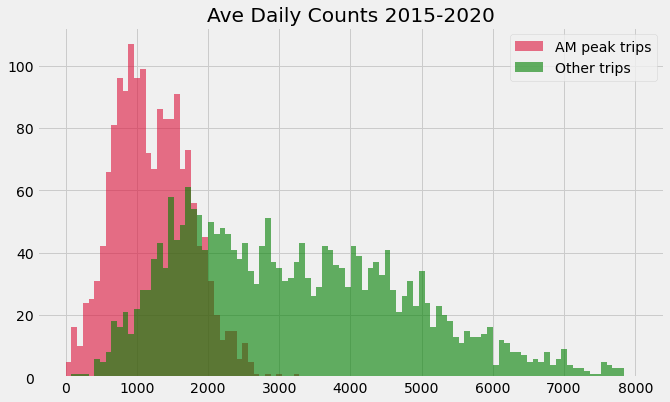

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df['am_peak_ttl'], range=(1,8000), bins=100, color='crimson', label='AM peak trips', alpha=0.6);
ax.hist(df['other_ttl'], range=(1,8000), bins=100, color='green', label ='Other trips', alpha=0.6);
ax.set_title("Ave Daily Counts 2015-2020")

ax.legend();


## STATS QUESTION 

> **What are boxplot statistics for these trips? What is 95% C.I. for AM peak daily counts?**

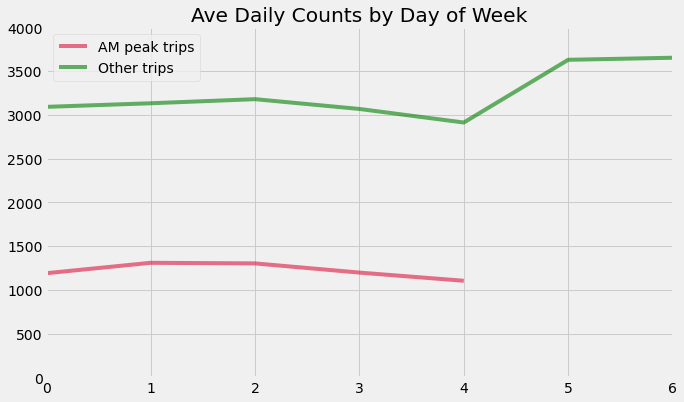

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(by_dow['dow'], by_dow['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.plot(by_dow['dow'], by_dow['other_ttl'], color = 'green', label ='Other trips', alpha=0.6);
ax.set_xlim(0,6)
ax.set_ylim(0,4000)
ax.set_title("Ave Daily Counts by Day of Week")

ax.legend();


In [109]:
by_dow_year = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl', 'year', 'month', 'dow']].groupby(['dow', 'year']).mean().reset_index()
by_dow_year['am_peak_ttl'].replace(0, np.NaN, inplace=True)
by_dow_year.head()


,dow,year,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl,month
0,0,2014,1098.557692,3477.961538,692.923077,405.634615,2163.365385,1314.596154,6.576923
1,0,2015,1182.211538,2987.865385,537.038462,645.173077,1297.038462,1690.826923,6.538462
2,0,2016,1167.346154,2904.384615,549.961538,617.384615,1264.826923,1639.557692,6.480769
3,0,2017,1176.519231,2765.480769,530.250000,646.269231,1159.865385,1605.615385,6.442308
4,0,2018,1167.773585,2794.207547,554.886792,612.886792,1304.962264,1489.245283,6.528302


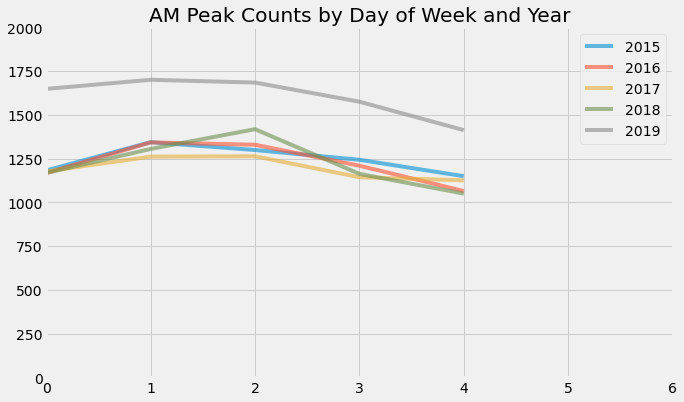

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
for yr in range(2015, 2020):
    ax.plot(by_dow['dow'], by_dow_year[by_dow_year['year'] == yr]['am_peak_ttl'], label=f'{yr}', alpha=0.6);
    
ax.set_xlim(0,6)
ax.set_ylim(0,2000)
ax.set_title("AM Peak Counts by Day of Week and Year")
ax.legend();
    
    

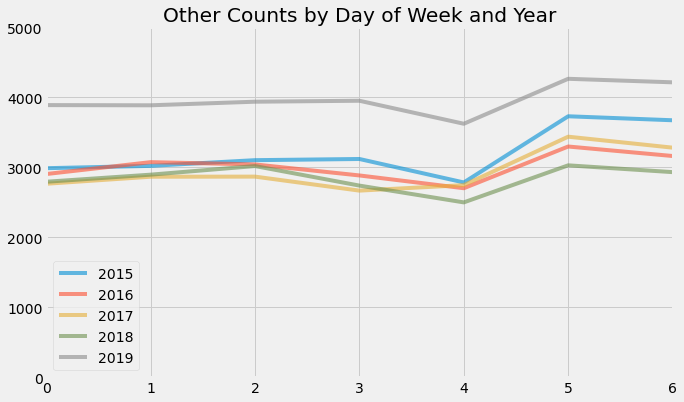

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
for yr in range(2015, 2020):
    ax.plot(by_dow['dow'], by_dow_year[by_dow_year['year'] == yr]['other_ttl'], label=f'{yr}', alpha=0.6);
    
ax.set_xlim(0,6)
ax.set_ylim(0,5000)
ax.set_title("Other Counts by Day of Week and Year")
ax.legend();
    
    

## STATS QUESTION 

> **Is Friday statistically the lowest riding day of the week?**

In [112]:
by_month = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl',  'month']].groupby('month').mean().reset_index()
by_month.head()

,month,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl
0,1,612.258065,1917.907834,314.188940,298.069124,931.866359,986.041475
1,2,615.617647,1999.141176,316.994118,298.623529,963.264706,1035.876471
2,3,620.778802,2535.783410,278.981567,341.797235,1029.516129,1506.267281
3,4,781.066667,3455.038095,368.871429,412.195238,1434.095238,2020.942857
4,5,1205.433180,4665.566820,499.949309,705.483871,1824.258065,2841.308756


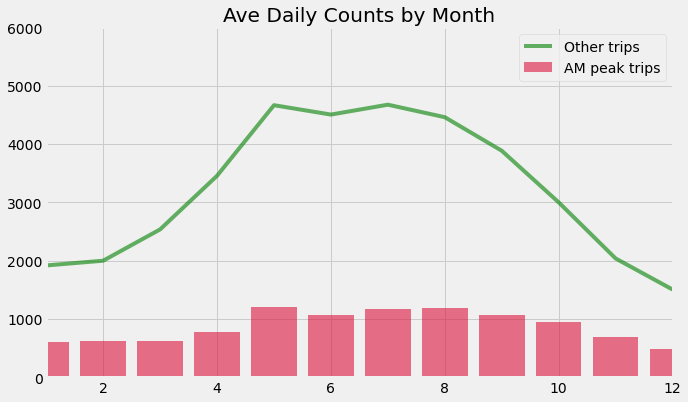

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_month['month'], by_month['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.plot(by_month['month'], by_month['other_ttl'], color = 'green', label='Other trips', alpha=0.6);
ax.set_xlim(1,12)
ax.set_ylim(0,6000)

ax.set_title("Ave Daily Counts by Month")
ax.legend()

In [114]:
by_year = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl',  'year']].groupby('year').mean().reset_index()
by_year.head()

,year,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl
0,2014,808.109589,3582.871233,508.235616,299.873973,2095.273973,1487.597260
1,2015,889.178082,3202.290411,395.553425,493.624658,1289.663014,1912.627397
2,2016,871.464481,3009.415301,403.374317,468.090164,1228.090164,1781.325137
3,2017,850.567123,2948.375342,382.306849,468.260274,1173.397260,1774.978082
4,2018,872.764384,2843.745205,406.906849,465.857534,1269.413699,1574.331507


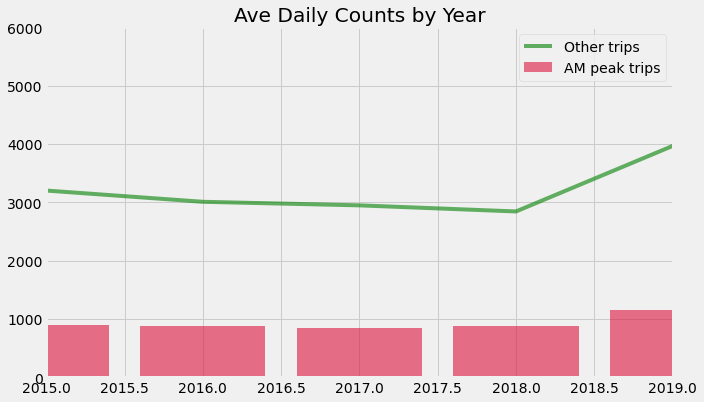

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_year['year'], by_year['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.plot(by_year['year'], by_year['other_ttl'], color = 'green', label='Other trips', alpha=0.6);
ax.set_xlim(2015, 2019)
ax.set_ylim(0,6000)

ax.set_title("Ave Daily Counts by Year")
ax.legend()

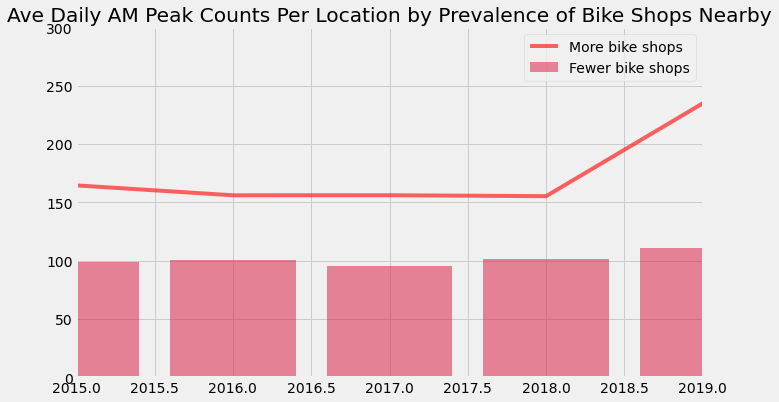

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_year['year'], by_year['few_am_peak_ttl']/4, color = 'crimson', label='Fewer bike shops', alpha=0.5);
ax.plot(by_year['year'], by_year['many_am_peak_ttl']/3, color = 'red', label='More bike shops', alpha=0.6);
ax.set_xlim(2015, 2019)
ax.set_ylim(0,300)

ax.set_title("Ave Daily AM Peak Counts Per Location by Prevalence of Bike Shops Nearby")
ax.legend();

## STATS QUESTION 

> **Is there a statistical difference between rider counts at locations with more nearby bikeshops than fewer?**

In [118]:
weather_by_time_of_trip = df[['am_peak_ttl', 'other_ttl', 'year', 'month', 'dow', 'PRCP', 'TAVG', 'TMIN', "TMAX"]]

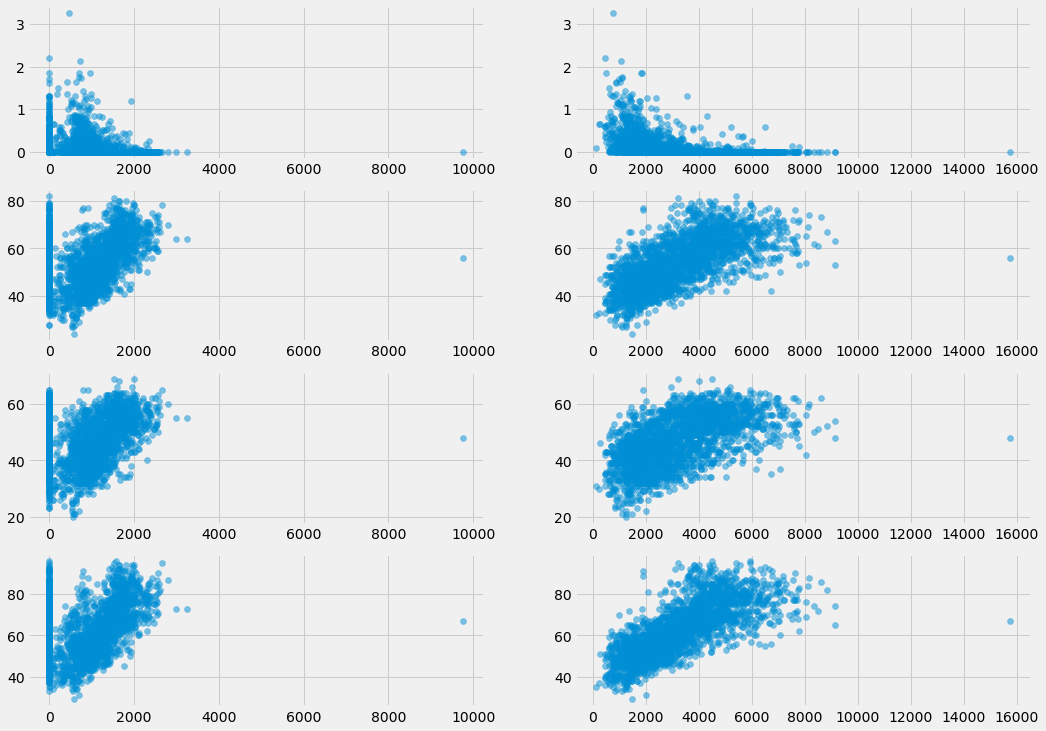

In [145]:
fig, axs = plt.subplots(4, 2, figsize = (16, 12))

for i in range(4):
    for j in range(2):
        axs[i][j].scatter(weather_by_time_of_trip.iloc[:,j], weather_by_time_of_trip.iloc[:, i+5], alpha=0.5)
        
# ax.plot(by_year['year'], by_year['many_am_peak_ttl']/3, color = 'red', label='More bike shops', alpha=0.6);
# ax.set_xlim(2015, 2019)
# ax.set_ylim(0,300)


## STATS QUESTION 

> **Is one temp variable more statistically collinear with ride counts than others? Max temp appears to have less of a scatter.**